# Code used to create tables in the MIMIC-III paper

## Table 2: MIMIC-II patient population by critical care unit

In [6]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psycopg2
%matplotlib inline

In [34]:
# Config
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'

In [35]:
# Connect to MIMIC
con = psycopg2.connect(dbname=dbname, user=sqluser)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)
# cur.close()
# con.close()

### Patient characteristics

How many charted observations are available for each ICU stay?

In [38]:
query = \
"""
WITH icuobs AS (
SELECT icustay_id, count(icustay_id) as obs
FROM chartevents
GROUP BY icustay_id)
SELECT avg(obs)
FROM icuobs;
"""

query_output = pd.read_sql_query(query,con)
print(query_output.head())

           avg
0  4267.534894


How many laboratory measurements are available for each hospitalization?

In [39]:
query = \
"""
WITH labobs AS (
SELECT hadm_id, count(hadm_id) as obs
FROM labevents
GROUP BY hadm_id)
SELECT avg(obs)
FROM labobs;
"""

query_output = pd.read_sql_query(query,con)
print(query_output.head())

          avg
0  380.592115


These are the details that we would like to include in Table 2, grouped by first careunit:

- Hospital admissions, no. (% of total admissions)
- Distinct ICU stays, no. (% of total unit stays)
- Age, yrs, mean ± SD
- Gender, male, percent of unit stays
- ICU length of stay, median days (IQR)
- Hospital length of stay, median days (IQR)
- ICU mortality, percent of unit stays
- Hospital mortality, percent of unit stays

### Extract and review the data

In [9]:
# Join admissions, icustays, and patients tables

query = \
"""
WITH population as (
SELECT a.subject_id, a.hadm_id, i.icustay_id, 
    a.admittime as hosp_admittime, a.dischtime as hosp_dischtime, 
    i.first_careunit, 
    DENSE_RANK() over(PARTITION BY a.hadm_id ORDER BY i.intime ASC) as icu_seq,
    p.dob, p.dod, i.intime as icu_intime, i.outtime as icu_outtime, 
    i.los as icu_los,
    round((EXTRACT(EPOCH FROM (a.dischtime-a.admittime))/60/60/24) :: NUMERIC, 4) as hosp_los, 
    p.gender, 
    round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age_hosp_in,
    round((EXTRACT(EPOCH FROM (i.intime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age_icu_in,
    hospital_expire_flag,
    CASE WHEN p.dod IS NOT NULL 
        AND p.dod >= i.intime - interval '6 hour'
        AND p.dod <= i.outtime + interval '6 hour' THEN 1 
        ELSE 0 END AS icu_expire_flag
FROM admissions a
INNER JOIN icustays i
ON a.hadm_id = i.hadm_id
INNER JOIN patients p
ON a.subject_id = p.subject_id
ORDER BY a.subject_id, i.intime
)
SELECT *
FROM population
WHERE age_hosp_in >= 16;
"""

query_output = pd.read_sql_query(query,con)
print(query_output.head())

   subject_id  hadm_id  icustay_id      hosp_admittime      hosp_dischtime  \
0           3   145834      211552 2101-10-20 19:08:00 2101-10-31 13:58:00   
1           4   185777      294638 2191-03-16 00:28:00 2191-03-23 18:41:00   
2           6   107064      228232 2175-05-30 07:15:00 2175-06-15 16:00:00   
3           9   150750      220597 2149-11-09 13:06:00 2149-11-14 10:15:00   
4          11   194540      229441 2178-04-16 06:18:00 2178-05-11 19:00:00   

  first_careunit  icu_seq        dob        dod          icu_intime  \
0           MICU        1 2025-04-11 2102-06-14 2101-10-20 19:10:11   
1           MICU        1 2143-05-12        NaT 2191-03-16 00:29:31   
2           SICU        1 2109-06-21        NaT 2175-05-30 21:30:54   
3           MICU        1 2108-01-26 2149-11-14 2149-11-09 13:07:02   
4           SICU        1 2128-02-22 2178-11-14 2178-04-16 06:19:32   

          icu_outtime  icu_los  hosp_los gender  age_hosp_in  age_icu_in  \
0 2101-10-26 20:43:09   6.06

### Distinct patients, no. (% of total admissions)

In [10]:
print('\nTotal patients: {}')\
    .format(len(query_output.subject_id.unique()))

print('\nNumber of patients by first careunit:\n')
print(query_output[['first_careunit','subject_id']] \
                    .drop_duplicates(['subject_id']) \
                    .groupby('first_careunit').count()).T
    
print('\nProportion of total hospital admissions:\n')
print(query_output[['first_careunit','subject_id']] \
                    .drop_duplicates(['subject_id']) \
                    .groupby('first_careunit') \
                    .count()/len(query_output.subject_id.unique())*100).T


Total patients: 38597

Number of patients by first careunit:

first_careunit   CCU  CSRU   MICU  SICU  TSICU
subject_id      5674  8091  13649  6372   4811

Proportion of total hospital admissions:

first_careunit        CCU       CSRU       MICU       SICU      TSICU
subject_id      14.700624  20.962769  35.362852  16.509055  12.464699


### Hospital admissions, no. (% of total admissions)

In [11]:
print('\nTotal hospital admissions: {}')\
    .format(len(query_output.hadm_id.unique()))

print('\nNumber of hospital admissions by first careunit:\n')
print(query_output[['first_careunit','hadm_id']] \
                    .drop_duplicates(['hadm_id']) \
                    .groupby('first_careunit').count()).T
    
print('\nProportion of total hospital admissions:\n')
print(query_output[['first_careunit','hadm_id']] \
                    .drop_duplicates(['hadm_id']) \
                    .groupby('first_careunit') \
                    .count()/len(query_output.hadm_id.unique())*100).T


Total hospital admissions: 49785

Number of hospital admissions by first careunit:

first_careunit   CCU  CSRU   MICU  SICU  TSICU
hadm_id         7258  9156  19770  8110   5491

Proportion of total hospital admissions:

first_careunit        CCU       CSRU       MICU       SICU      TSICU
hadm_id         14.578688  18.391082  39.710756  16.290047  11.029427


### Distinct ICU stays, no. (% of total unit stays)

In [12]:
print('\nTotal ICU stays: {}')\
    .format(len(query_output.icustay_id.unique()))

print('\nNumber of ICU stays by careunit:\n')
print(query_output[['first_careunit','icustay_id']] \
          .groupby('first_careunit').count()).T

print('\nProportion of total ICU stays:\n')
print(query_output[['first_careunit','icustay_id']] \
          .groupby('first_careunit') \
          .count()/len(query_output.icustay_id.unique())*100).T


Total ICU stays: 53423

Number of ICU stays by careunit:

first_careunit   CCU  CSRU   MICU  SICU  TSICU
icustay_id      7726  9854  21087  8891   5865

Proportion of total ICU stays:

first_careunit        CCU       CSRU       MICU       SICU      TSICU
icustay_id      14.461936  18.445239  39.471763  16.642645  10.978418


### Age, yrs, median ± IQR

In [13]:
# Better to report median IQR because >89 appear as 300
print('Median age, years: {} ').format(query_output.age_icu_in.median())
print('Lower quartile age, years: {} ').format(query_output.age_icu_in.quantile(0.25))
print('Upper quartile age, years: {} \n ').format(query_output.age_icu_in.quantile(0.75))

print('Median age by careunit, years:\n ')
print(query_output[['first_careunit','age_icu_in']] \
      .groupby('first_careunit').median()).T

print('\nLower quartile by careunit, years:\n ')
print(query_output[['first_careunit','age_icu_in']] \
      .groupby('first_careunit').quantile(0.25)).T

print('\nUpper quartile by careunit, years:\n ')
print(query_output[['first_careunit','age_icu_in']] \
      .groupby('first_careunit').quantile(0.75)).T


Median age, years: 65.769 
Lower quartile age, years: 52.8361 
Upper quartile age, years: 77.80005 
 
Median age by careunit, years:
 
first_careunit      CCU      CSRU     MICU     SICU    TSICU
age_icu_in      70.5697  67.60415  64.9124  63.5819  59.8667

Lower quartile by careunit, years:
 
first_careunit       CCU       CSRU     MICU      SICU    TSICU
age_icu_in      58.44555  57.606375  51.6559  51.44315  42.9378

Upper quartile by careunit, years:
 
first_careunit        CCU       CSRU      MICU     SICU    TSICU
age_icu_in      80.541375  76.681425  78.17095  76.4575  75.6518


### Gender, male, percent of unit stays

In [14]:
print('Gender:\n')
print(query_output.loc[query_output.icu_seq==1].groupby('gender').gender.count())
print(query_output.loc[query_output.icu_seq==1].groupby('gender').gender.count() \
     /query_output.loc[query_output.icu_seq==1].gender.count()*100)

print('Gender by careunit:\n')
print(query_output.loc[query_output.icu_seq==1] \
    .groupby(['first_careunit','gender']).gender.count())

print('\nProportion by unit:\n')
print(query_output.loc[query_output.icu_seq==1] \
    .groupby(['first_careunit','gender']) \
    .gender.count()/query_output.loc[query_output.icu_seq==1] \
    .groupby(['first_careunit']).gender.count())*100

Gender:

gender
F    21802
M    27983
Name: gender, dtype: int64
gender
F    43.792307
M    56.207693
Name: gender, dtype: float64
Gender by careunit:

first_careunit  gender
CCU             F          3055
                M          4203
CSRU            F          3156
                M          6000
MICU            F          9577
                M         10193
SICU            F          3859
                M          4251
TSICU           F          2155
                M          3336
Name: gender, dtype: int64

Proportion by unit:

first_careunit  gender
CCU             F         42.091485
                M         57.908515
CSRU            F         34.469201
                M         65.530799
MICU            F         48.442084
                M         51.557916
SICU            F         47.583231
                M         52.416769
TSICU           F         39.246039
                M         60.753961
Name: gender, dtype: float64


### ICU length of stay, median days (IQR)

In [15]:
print('Median ICU length of stay, days: {}').format(query_output.icu_los.median())
print('Lower quartile ICU length of stay, days: {}') \
    .format(query_output.icu_los.quantile(0.25))
print('Upper quartile ICU length of stay, days: {}\n') \
    .format(query_output.icu_los.quantile(0.75))

print('Median length of ICU stay by careunit, days:\n ')
print(query_output[['first_careunit','icu_los']] \
      .groupby('first_careunit').median()).T

print('\nLower quartile length of ICU stay, days:\n ')
print(query_output[['first_careunit','icu_los']] \
      .groupby('first_careunit').quantile(0.25)).T

print('\nUpper quartile length of ICU stay, days:\n ')
print(query_output[['first_careunit','icu_los']] \
      .groupby('first_careunit').quantile(0.75)).T


Median ICU length of stay, days: 2.14425
Lower quartile ICU length of stay, days: 1.2056
Upper quartile ICU length of stay, days: 4.19255

Median length of ICU stay by careunit, days:
 
first_careunit      CCU    CSRU    MICU    SICU   TSICU
icu_los         2.19775  2.1549  2.0956  2.2522  2.1015

Lower quartile length of ICU stay, days:
 
first_careunit       CCU    CSRU    MICU     SICU   TSICU
icu_los         1.213225  1.2162  1.1892  1.25155  1.1635

Upper quartile length of ICU stay, days:
 
first_careunit      CCU   CSRU    MICU    SICU   TSICU
icu_los         4.14855  4.002  4.0958  4.9327  4.5853


### Hospital length of stay, median days (IQR)

In [16]:
# NB: hadm_id is repeated in data due to multiple ICU stays
# ...so need to drop duplicates
print('Median length of hospital stay, days: {}') \
    .format(query_output.drop_duplicates(['hadm_id']).hosp_los.median())
print('Lower quartile length of hospital stay, days: {}') \
    .format(query_output.drop_duplicates(['hadm_id']).hosp_los.quantile(0.25))
print('Upper quartile length of hospital stay, days: {}\n') \
    .format(query_output.drop_duplicates(['hadm_id']).hosp_los.quantile(0.75))

print('Median length of hospital stay, days:\n ')
print(query_output.drop_duplicates(['hadm_id']) \
      [['first_careunit','hosp_los']] \
      .groupby('first_careunit').median()).T

print('\nLower quartile length of hospital stay, days:\n ')
print(query_output.drop_duplicates(['hadm_id']) \
      [['first_careunit','hosp_los']] \
      .groupby('first_careunit').quantile(0.25)).T

print('\nUpper quartile length of hospital stay, days:\n ')
print(query_output.drop_duplicates(['hadm_id']) \
      [['first_careunit','hosp_los']] \
      .groupby('first_careunit').quantile(0.75)).T

Median length of hospital stay, days: 6.9111
Lower quartile length of hospital stay, days: 4.0264
Upper quartile length of hospital stay, days: 11.9354

Median length of hospital stay, days:
 
first_careunit     CCU     CSRU    MICU    SICU   TSICU
hosp_los        5.7576  7.37465  6.4229  7.9313  7.4472

Lower quartile length of hospital stay, days:
 
first_careunit       CCU    CSRU      MICU    SICU    TSICU
hosp_los        3.105075  5.2396  3.673775  4.4146  4.07045

Upper quartile length of hospital stay, days:
 
first_careunit        CCU       CSRU      MICU       SICU     TSICU
hosp_los        10.026225  11.351575  11.73025  14.240125  13.58505


### ICU mortality, percent of unit stays

In [17]:
print('ICU mortality, number:\n')
print(query_output \
    .groupby(['icu_expire_flag']) \
    .icu_expire_flag.count())

print('\nICU mortality, %:\n')
print(query_output.groupby(['icu_expire_flag']) \
    .icu_expire_flag.count() / query_output.icu_expire_flag.count()*100)

print('\nICU mortality by careunit:\n')
print(query_output \
    .groupby(['first_careunit','icu_expire_flag']) \
    .icu_expire_flag.count())

print('\nProportion by unit:\n')
print(query_output \
    .groupby(['first_careunit','icu_expire_flag']) \
    .icu_expire_flag.count()/query_output \
    .groupby(['first_careunit']).icu_expire_flag.count())*100

ICU mortality, number:

icu_expire_flag
0    48858
1     4565
Name: icu_expire_flag, dtype: int64

ICU mortality, %:

icu_expire_flag
0    91.454991
1     8.545009
Name: icu_expire_flag, dtype: float64

ICU mortality by careunit:

first_careunit  icu_expire_flag
CCU             0                   7041
                1                    685
CSRU            0                   9501
                1                    353
MICU            0                  18865
                1                   2222
SICU            0                   8078
                1                    813
TSICU           0                   5373
                1                    492
Name: icu_expire_flag, dtype: int64

Proportion by unit:

first_careunit  icu_expire_flag
CCU             0                  91.133834
                1                   8.866166
CSRU            0                  96.417698
                1                   3.582302
MICU            0                  89.462702
            

### Hospital mortality, percent of unit stays

In [18]:
# NB: hadm_id is repeated in data due to multiple ICU stays
# ...so need to drop duplicates
print('Hospital mortality, number:\n')
print(query_output.drop_duplicates(['hadm_id']) \
    .groupby(['hospital_expire_flag']) \
    .hospital_expire_flag.count())

print('\nHospital mortality, %:\n')
print(query_output.drop_duplicates(['hadm_id']) \
    .groupby(['hospital_expire_flag']) \
    .hospital_expire_flag.count() \
    / query_output.drop_duplicates(['hadm_id']).hospital_expire_flag.count()*100)

print('\nHospital mortality:\n')
print(query_output.drop_duplicates(['hadm_id']) \
    .groupby(['first_careunit','hospital_expire_flag']) \
    .hospital_expire_flag.count())

print('\nProportion by unit:\n')
print(query_output.drop_duplicates(['hadm_id']) \
    .groupby(['first_careunit','hospital_expire_flag']) \
    .hospital_expire_flag.count()/query_output.drop_duplicates(['hadm_id']) \
    .groupby(['first_careunit']).hospital_expire_flag.count())*100

Hospital mortality, number:

hospital_expire_flag
0    44037
1     5748
Name: hospital_expire_flag, dtype: int64

Hospital mortality, %:

hospital_expire_flag
0    88.454354
1    11.545646
Name: hospital_expire_flag, dtype: float64

Hospital mortality:

first_careunit  hospital_expire_flag
CCU             0                        6441
                1                         817
CSRU            0                        8732
                1                         424
MICU            0                       16911
                1                        2859
SICU            0                        7090
                1                        1020
TSICU           0                        4863
                1                         628
Name: hospital_expire_flag, dtype: int64

Proportion by unit:

first_careunit  hospital_expire_flag
CCU             0                       88.743455
                1                       11.256545
CSRU            0                       95.369157

## Table 3: Distribution of primary ICD-9 codes in MIMIC-II

In [19]:
# Connect to MIMIC
con = psycopg2.connect(dbname=dbname, user=sqluser)
cur = con.cursor()
cur.execute('SET search_path to ' + schema_name)
# cur.close()
# con.close()

In [20]:
# ICD Diagnoses are associated with hospital admissions, not ICU stay
# ...so select first ICU stay for breakdown.
# Select patients >= 16 on first admission

query = \
"""
WITH diagnoses_icu AS (
SELECT a.subject_id, a.hadm_id, i.icustay_id, 
    a.admittime as hosp_admittime, a.dischtime as hosp_dischtime, 
    i.first_careunit, 
    DENSE_RANK() over(PARTITION BY a.hadm_id ORDER BY i.intime ASC) as icu_seq,
    p.dob, p.dod, i.intime as icu_intime, i.outtime as icu_outtime, 
    i.los as icu_los,
    round((EXTRACT(EPOCH FROM (a.dischtime-a.admittime))/60/60/24) :: NUMERIC, 4) as hosp_los, 
    p.gender, 
    round((EXTRACT(EPOCH FROM (a.admittime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age_hosp_in,
    round((EXTRACT(EPOCH FROM (i.intime-p.dob))/60/60/24/365.242) :: NUMERIC, 4) as age_icu_in,
    hospital_expire_flag,
    CASE WHEN p.dod IS NOT NULL 
        AND p.dod >= i.intime - interval '6 hour'
        AND p.dod <= i.outtime + interval '6 hour' THEN 1 
        ELSE 0 END AS icu_expire_flag
    FROM admissions a
    INNER JOIN icustays i
    ON a.hadm_id = i.hadm_id
    INNER JOIN patients p
    ON a.subject_id = p.subject_id
    ORDER BY a.subject_id, i.intime)
SELECT d.subject_id, d.hadm_id, d.icustay_id, d.first_careunit,
    icd.seq_num, icd.icd9_code, left(icd.icd9_code,3) AS icd_first3, 
    CASE
        WHEN lower(LEFT(icd.icd9_code,1)) = 'e' THEN NULL
        WHEN lower(LEFT(icd.icd9_code,1)) = 'v' THEN NULL
        ELSE CAST( LEFT(icd.icd9_code,3) AS INT) END AS icd_first3_num,
    CASE 
        WHEN lower(LEFT(icd.icd9_code,1)) = 'e' THEN 9
        WHEN lower(LEFT(icd.icd9_code,1)) = 'v' THEN 9
        WHEN CAST( LEFT(icd.icd9_code,3) AS INT) >=0 
            AND CAST( LEFT(icd.icd9_code,3) AS INT) <= 139 THEN 0
        WHEN CAST( LEFT(icd.icd9_code,3) AS INT) >=140 
            AND CAST( LEFT(icd.icd9_code,3) AS INT) <= 239 THEN 1
        WHEN CAST( LEFT(icd.icd9_code,3) AS INT) >=240 
            AND CAST( LEFT(icd.icd9_code,3) AS INT) <= 279 THEN 2
        WHEN CAST( LEFT(icd.icd9_code,3) AS INT) >=390 
            AND CAST( LEFT(icd.icd9_code,3) AS INT) <= 459 THEN 3
        WHEN CAST( LEFT(icd.icd9_code,3) AS INT) >=460 
            AND CAST( LEFT(icd.icd9_code,3) AS INT) <= 519 THEN 4
        WHEN CAST( LEFT(icd.icd9_code,3) AS INT) >=520 
            AND CAST( LEFT(icd.icd9_code,3) AS INT) <= 579 THEN 5
        WHEN CAST( LEFT(icd.icd9_code,3) AS INT) >=580 
            AND CAST( LEFT(icd.icd9_code,3) AS INT) <= 629 THEN 6
        WHEN CAST( LEFT(icd.icd9_code,3) AS INT) >=800 
            AND CAST( LEFT(icd.icd9_code,3) AS INT) <= 959 THEN 7
        WHEN CAST( LEFT(icd.icd9_code,3) AS INT) >=960 
            AND CAST( LEFT(icd.icd9_code,3) AS INT) <= 989 THEN 8
        ELSE 9 END AS icd_first3_grp, 
    d_icd.short_title
FROM diagnoses_icu d
INNER JOIN diagnoses_icd icd
    ON d.hadm_id = icd.hadm_id
INNER JOIN d_icd_diagnoses d_icd
    ON icd.icd9_code = d_icd.icd9_code
WHERE seq_num =1
    AND age_hosp_in >=16;
"""

query_output = pd.read_sql_query(query,con)
print(query_output.head())

   subject_id  hadm_id  icustay_id first_careunit  seq_num icd9_code  \
0           3   145834      211552           MICU        1      0389   
1           4   185777      294638           MICU        1       042   
2           6   107064      228232           SICU        1     40391   
3           9   150750      220597           MICU        1       431   
4          11   194540      229441           SICU        1      1913   

  icd_first3  icd_first3_num  icd_first3_grp               short_title  
0        038              38               0            Septicemia NOS  
1        042              42               0    Human immuno virus dis  
2        403             403               3    Hyp kid NOS w cr kid V  
3        431             431               3  Intracerebral hemorrhage  
4        191             191               1     Mal neo parietal lobe  


### Most common ICD-9 codes

In [21]:
print('Primary ICD diagnoses by frequency:\n')
print(query_output.drop_duplicates(['hadm_id'])['icd9_code'].value_counts().head())

print('\nPrimary ICD diagnoses, %:\n')
print(query_output.drop_duplicates(['hadm_id'])['icd9_code'].value_counts().head() \
     /len(query_output.drop_duplicates(['hadm_id'])['icd9_code'])*100)

Primary ICD diagnoses by frequency:

41401    3496
0389     2069
41071    1751
4241     1140
51881    1127
dtype: int64

Primary ICD diagnoses, %:

41401    7.122629
0389     4.215309
41071    3.567427
4241     2.322596
51881    2.296111
dtype: float64


### ICD-9 codes by careunit

In [22]:
print('Primary ICD diagnoses by ICU stay:\n')
a=query_output.drop_duplicates(['hadm_id']).loc[query_output.first_careunit=='CCU']['icd_first3_grp'].value_counts()
b=query_output.drop_duplicates(['hadm_id']).loc[query_output.first_careunit=='CSRU']['icd_first3_grp'].value_counts()
c=query_output.drop_duplicates(['hadm_id']).loc[query_output.first_careunit=='MICU']['icd_first3_grp'].value_counts()
d=query_output.drop_duplicates(['hadm_id']).loc[query_output.first_careunit=='SICU']['icd_first3_grp'].value_counts()
e=query_output.drop_duplicates(['hadm_id']).loc[query_output.first_careunit=='TSICU']['icd_first3_grp'].value_counts()
f=query_output.drop_duplicates(['hadm_id'])['icd_first3_grp'].value_counts()
df_num=pd.concat([a,b,c,d,e,f],axis=1)
df_num.fillna(value=0, inplace=True)
df_num.columns = ['CCU', 'CSRU','MICU','SICU','TSICU','Total']
# Append a totals row
print(df_num.append(df_num.sum(), ignore_index=True))

print('\nProportion by careunit:\n')
a=(a/query_output.drop_duplicates(['hadm_id']).loc[query_output.first_careunit=='CCU']['icd_first3_grp'].count())*100
b=(b/query_output.drop_duplicates(['hadm_id']).loc[query_output.first_careunit=='CSRU']['icd_first3_grp'].count())*100
c=(c/query_output.drop_duplicates(['hadm_id']).loc[query_output.first_careunit=='MICU']['icd_first3_grp'].count())*100
d=(d/query_output.drop_duplicates(['hadm_id']).loc[query_output.first_careunit=='SICU']['icd_first3_grp'].count())*100
e=(e/query_output.drop_duplicates(['hadm_id']).loc[query_output.first_careunit=='TSICU']['icd_first3_grp'].count())*100
f=(f/query_output.drop_duplicates(['hadm_id'])['icd_first3_grp'].count())*100
df_percent=pd.concat([a,b,c,d,e,f],axis=1)
df_percent.fillna(value=0, inplace=True)
df_percent.columns = ['CCU', 'CSRU','MICU','SICU','TSICU','Total']
# Append a totals row
print(df_percent.append( df_num.sum() * 100 / df_num.Total.sum(), ignore_index=True))

Primary ICD diagnoses by ICU stay:

     CCU  CSRU   MICU  SICU  TSICU  Total
0    305    72   3229   448    152   4206
1    126   287   1415  1225    466   3519
2    104    36    985   178     54   1357
3   5131  7138   2638  2356    684  17947
4    416   141   3393   390    225   4565
5    264   157   3046  1193    440   5100
6    130    14    738   101     31   1014
7     97   494    480   836   2809   4716
8     50     2    584    58     11    705
9    565   739   2883  1204    563   5954
10  7188  9080  19391  7989   5435  49083

Proportion by careunit:

          CCU       CSRU       MICU       SICU      TSICU       Total
0    4.243183   0.792952  16.652055   5.607711   2.796688    8.569158
1    1.752922   3.160793   7.297200  15.333584   8.574057    7.169488
2    1.446856   0.396476   5.079676   2.228064   0.993560    2.764705
3   71.382860  78.612335  13.604249  29.490550  12.585097   36.564595
4    5.787423   1.552863  17.497808   4.881712   4.139834    9.300572
5    3.672788 

### Distribution of ICD codes, normalised by careunit

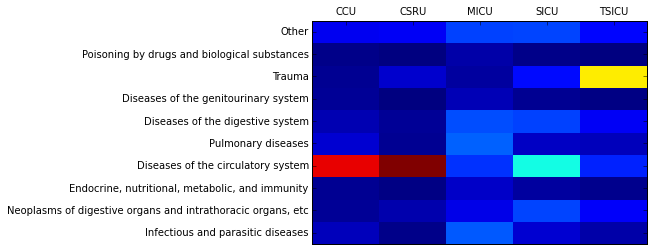

In [23]:
data = df_percent[['CCU', 'CSRU','MICU','SICU','TSICU']].values
row_labels = list(['CCU', 'CSRU','MICU','SICU','TSICU'])
column_labels = list(
    ['Infectious and parasitic diseases',
     'Neoplasms of digestive organs and intrathoracic organs, etc',
     'Endocrine, nutritional, metabolic, and immunity',
     'Diseases of the circulatory system',
     'Pulmonary diseases',
     'Diseases of the digestive system',
     'Diseases of the genitourinary system',
     'Trauma',
     'Poisoning by drugs and biological substances',
     'Other'])
fig, ax = plt.subplots()
heatmap = ax.pcolor(data, cmap=plt.cm.jet)

# move labels to top
ax.xaxis.tick_top()

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(data.shape[1])+0.5, minor=False)
ax.set_yticks(np.arange(data.shape[0])+0.5, minor=False)

ax.set_xticklabels(row_labels, minor=False)
ax.set_yticklabels(column_labels, minor=False)
plt.show()

In [24]:
print df_num

    CCU  CSRU  MICU  SICU  TSICU  Total
0   305    72  3229   448    152   4206
1   126   287  1415  1225    466   3519
2   104    36   985   178     54   1357
3  5131  7138  2638  2356    684  17947
4   416   141  3393   390    225   4565
5   264   157  3046  1193    440   5100
6   130    14   738   101     31   1014
7    97   494   480   836   2809   4716
8    50     2   584    58     11    705
9   565   739  2883  1204    563   5954


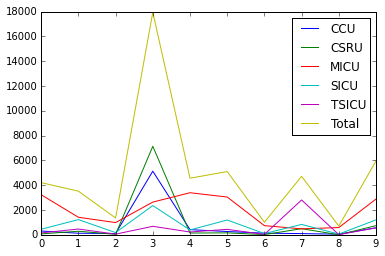

In [25]:
df_num.plot()